# Univariate LSTM to Predict Temperature and Humidity 

In [5]:
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Load Data

In [6]:
# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/repos/iot-htsensor/data/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')

# parse date, insert as column for sanity checking
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))

# create index
df.set_index('datetime', inplace=True)

# extract relevant columns and rename
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)

# filter years
filter = (df.index.year >= 2000) & (df.index.year <= 2016) 

# filter columns
df = df.loc[filter,['D_Temp', 'D_Humi']]

# resample
frequency = 'W'

df = df.resample(frequency).mean()

# interpolate missing values
df = df.interpolate()

## fill na with mean valued :: df.resample("1d").sum().fillna(0).rolling(window=3, min_periods=1).mean()

df.head()

,D_Temp,D_Humi
datetime,,
2000-01-02,3.908333,89.895833
2000-01-09,4.868452,85.154762
2000-01-16,0.474405,88.089286
2000-01-23,1.841667,84.583333
2000-01-30,0.985119,79.250000


In [69]:
df.shape

(48, 2)

In [8]:

# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv

# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

# load all data
dataset = read_csv('/Users/stewarta/Documents/DATA/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [9]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [10]:
# split the power usage dataset into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


## LSTM 

The LSTM Model:


### Train and Predict

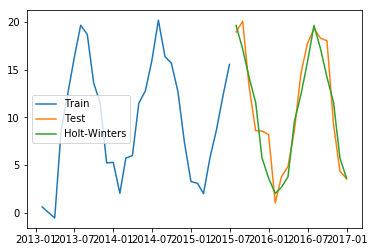

In [70]:
# univariate multi-step lstm for the power usage dataset


# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

## SARIMA


The Python implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.

Trend Elements
p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

Seasonal Elements
P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.



###
Testing Stationary

Null Hypothesis (H0): If failed to be rejected, it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [98]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd =  timeseries.rolling(10).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

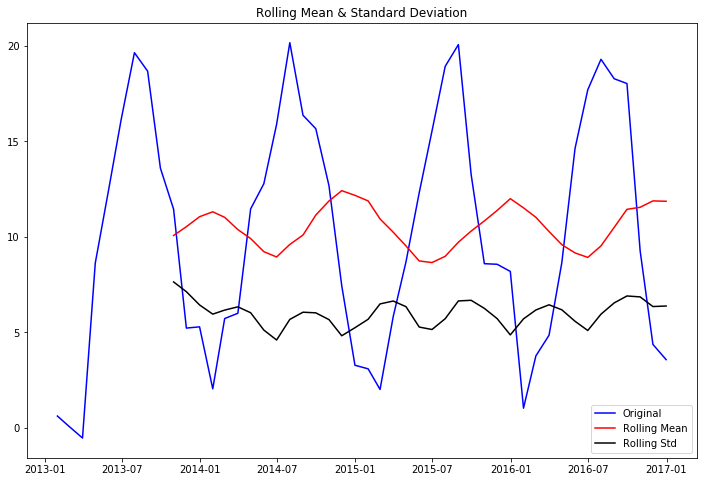

Results of Dickey-Fuller Test:
Test Statistic                 -4.476573
p-value                         0.000217
#Lags Used                      7.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


In [99]:
test_stationarity(df.D_Temp)

### Train and Predict

                           Statespace Model Results                           
Dep. Variable:                 D_Temp   No. Observations:                   37
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -102.198
Date:                Sun, 27 Jan 2019   AIC                            208.397
Time:                        18:28:43   BIC                            211.618
Sample:                    01-31-2013   HQIC                           209.532
                         - 01-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9291      0.051     18.383      0.000       0.830       1.028
sigma2        13.9099      3.954      3.518      0.000       6.160      21.660
Ljung-Box (Q):                      122.35   Jarque-

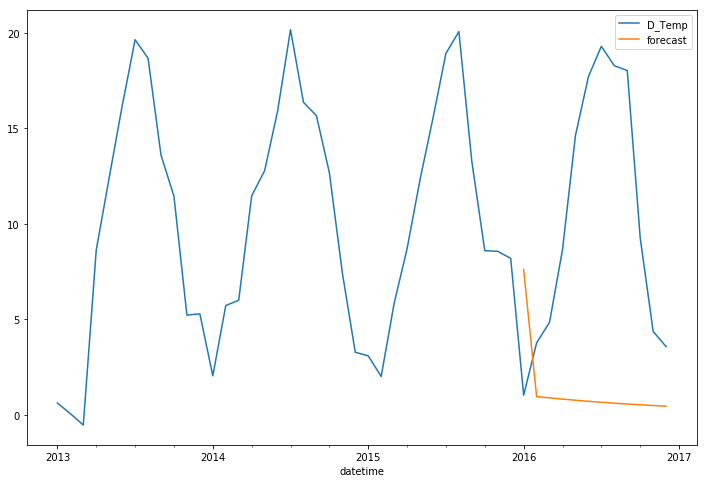

In [156]:
import statsmodels.api as sm  


mod = sm.tsa.statespace.SARIMAX(df.loc[:'2016-01-31',['D_Temp']])
results = mod.fit()
print (results.summary())

df['forecast'] = results.predict(start=36, end=48)  
df[['D_Temp', 'forecast']].plot(figsize=(12, 8)) 
